### Setup

In [1]:
from neuron import h
from cell_inference.config import params, paths
import pandas as pd

h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD_OBLIQUE, index_col='id')
h.dt = params.DT

h.tstop = 200.

### Setup smiulation parameters

In [2]:
import numpy as np
import json

# Biophysical parameters
filepath = './cell_inference/resources/biophys_parameters/neuronal_model_491766131.json'
f = open(filepath)
biophys_param = json.load(f)
f.close()

In [3]:
# biophys = np.array([0.000119174, 0.000095700, 0.00041148, 0.00147346])*(1) # scale g_pas

# Ra: basal, trunk, tuft
biophys = np.array([200, 50, 120])
# biophys = np.array([0.00012, 0.0001, 0.0004, 0.0015]) # fix g_pas
biophys_comm = {} #{'cm': 3.05}

# (soma r,trunk l,trunk r,basal r,tuft r,dend l,axon r, oblique r, oblique l)
geo_param = [7., 450., .6, .35, .1, 150., .15, .25, 100.] # [7., 500., .25, .2, .2, 200., .18] [7., 400., .45, .48, .35, 150., .2, 100.]
loc_param = [0., 350., 80., 0.0, 1.0, 0.] # position (x,y,z,alpha,h,phi)

In [4]:
ncell = 1
biophys = np.tile(biophys,(ncell,1)) 
# biophys[:,5] = np.linspace(200, 300, ncell)
biophys = np.append(biophys,biophys[[0],:],axis=0)
print(biophys)

[[200  50 120]
 [200  50 120]]


In [5]:
geo_param = np.tile(geo_param,(ncell,1))
# geo_param[:,6] = np.linspace(.1, .2, ncell)
# geo_param[:,[2,3,4,6]] *= 1.0 # scale radius
geo_param = np.append(geo_param,geo_param[[0],:],axis=0)
print(geo_param)

[[7.0e+00 4.5e+02 6.0e-01 3.5e-01 1.0e-01 1.5e+02 1.5e-01 2.5e-01 1.0e+02]
 [7.0e+00 4.5e+02 6.0e-01 3.5e-01 1.0e-01 1.5e+02 1.5e-01 2.5e-01 1.0e+02]]


In [6]:
gmax = [0.]*ncell + [0.02]
ncell += 1

In [7]:
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes

sim = Simulation(geometry = geo_standard,
                 electrodes = np.zeros((1,3)),
                 full_biophys = biophys_param,
                 cell_type = CellTypes.ACTIVE_FULL,
                 biophys = biophys,
                 biophys_comm = biophys_comm,
                 loc_param = loc_param,
                 geo_param = geo_param,
                 gmax = gmax,
                 stim_param = {'start': 5.},
                 scale = 1.,
                 ncell = ncell)

#### Add current injection

In [8]:
for cell in sim.cells[:-1]:
    cell.add_injection(sec_index=0, pulse=True, amp=-0.010, delay=50.0, dur=150.0)

#### Record axial current

In [9]:
from cell_inference.utils.currents.somaaxialcurrent import Soma_Axial_Current

# ac_idx = [0]
ac_idx = [0,-1]
axial_current = [Soma_Axial_Current(sim.cells[i].soma,single_seg=True) for i in ac_idx]

### Simulation results

In [10]:
sim.run_neuron_sim()
# lfp = sim.get_lfp().T
t = sim.t()
v = sim.v('all')

#### Membrane voltage

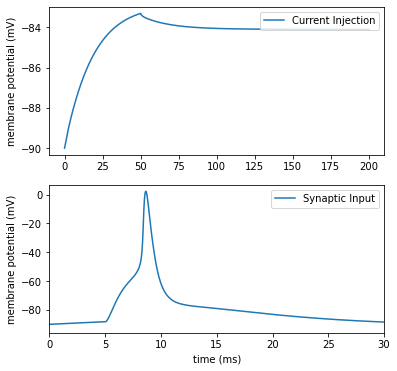

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6,6))
plt.subplot(211)
plt.plot(t,v[0],label='Current Injection')
plt.ylabel('membrane potential (mV)');
plt.legend(loc=1)
plt.subplot(212)
plt.plot(t,v[-1],label='Synaptic Input')
plt.ylabel('membrane potential (mV)');
plt.legend(loc=1)
plt.xlabel('time (ms)')
plt.xlim([0,30])
plt.show()

#### Calculate passive properties

In [12]:
from cell_inference.utils.metrics.measure_passive_properties import measure_passive_properties
%matplotlib inline

# plt.figure(figsize=(6,3*(ncell-1)))
# for i in range(ncell-1):
#     plt.subplot(ncell-1,1,i+1)
#     Vrest, Rin, Tau = measure_passive_properties(v[i],t,sim.cells[i].injection[0].pp_obj,ax=plt.gca())
#     print((Vrest, Rin, Tau))

for i in range(ncell-1):
    Vrest, Rin, Tau = measure_passive_properties(v[i],t,sim.cells[i].injection[0].pp_obj)
    print((Vrest, Rin, Tau))

(-83.30730725705385, 79.72261024426501, 15.625000000003546)


#### Axial currents

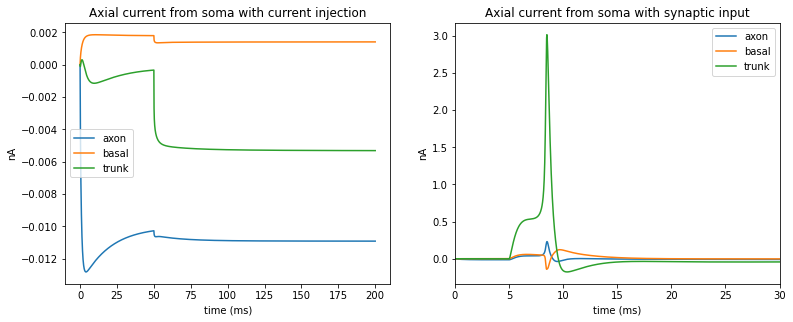

In [13]:
dend_types = axial_current[0].dend_type

plt.figure(figsize=(12.8, 4.8))
for i,AC in enumerate(axial_current):
    plt.subplot(1,2,i+1)
    ac = AC.get_current()
    for dend_type in dend_types:
        plt.plot(t,ac[dend_type].ravel(),label=dend_type)
    plt.ylabel('nA')
    plt.legend()
    if i==len(axial_current)-1:
        plt.title('Axial current from soma with synaptic input')
        plt.xlim([0,30])
    else:
        plt.title('Axial current from soma with current injection')
    plt.xlabel('time (ms)')
plt.show()

#### Get segment coordinates for given cell and calculate electrotonic distance

In [14]:
from cell_inference.utils.metrics.measure_segment_distance import measure_segment_distance

cell = sim.cells[-1]
soma = cell.soma
section_list = cell.all
sec_type_swc = {sec['name']: sec['type'] for _, sec in geo_standard.iterrows()}
sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in section_list]
freq = 0 # Hz

seg_prop, Rin, Rin_pha = measure_segment_distance(soma, section_list, sec_type, freq)
print(Rin, Rin_pha) # Megohms, rad

127.22078750696267 0.0


In [15]:
seg_coords = cell.seg_coords

tstart = sim.stim.start
dur = 7
t_idx = (t>=tstart) & (t<=tstart+dur)
im = sim.lfp[-1].calc_im()[:, t_idx]
# im_den = im / np.expand_dims(seg_prop['seg_area'], 1) # nA/um^2
im_den = im / np.diff(seg_prop['distance'], axis=1) # nA/um

select_seg = None
# select_seg = seg_prop['swc_type'] != 1 # excluding soma

var = im_den
varname = 'Transmembrane current density per unit length (nA/um)'
axes = ['x', 'y']
n_dist = 10
max_per_dist = 2
space = 0.01
normalized_space = False
sort_by_dist = True
figsize = (12,9)
fontsize = 15
scalebar_size = 50

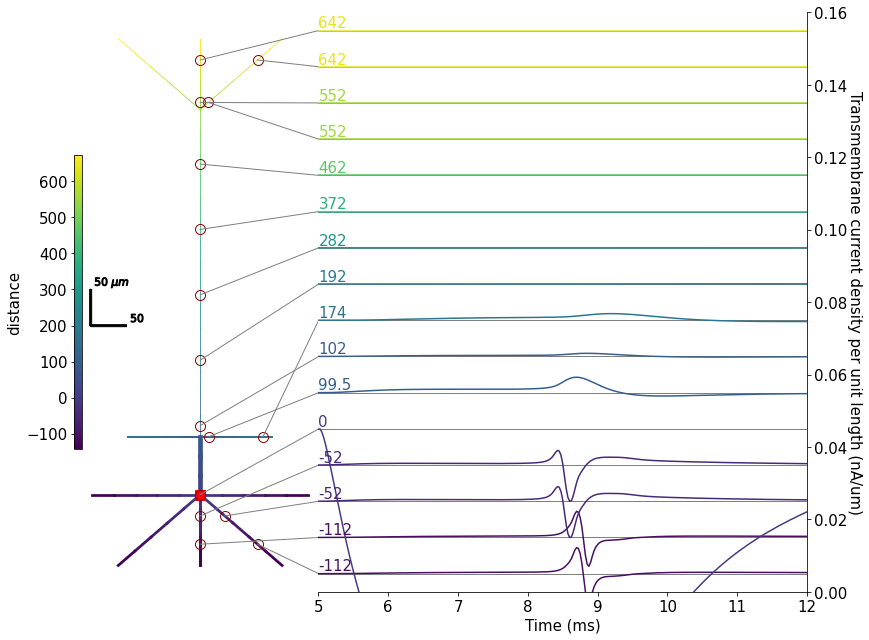

In [16]:
from cell_inference.utils.plotting.plot_variable_with_morphology import plot_variable_with_morphology
%matplotlib inline

_ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t[t_idx], axes=axes,
                                  distance_type='distance', n_dist=n_dist,
                                  select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
                                  space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
                                  figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)

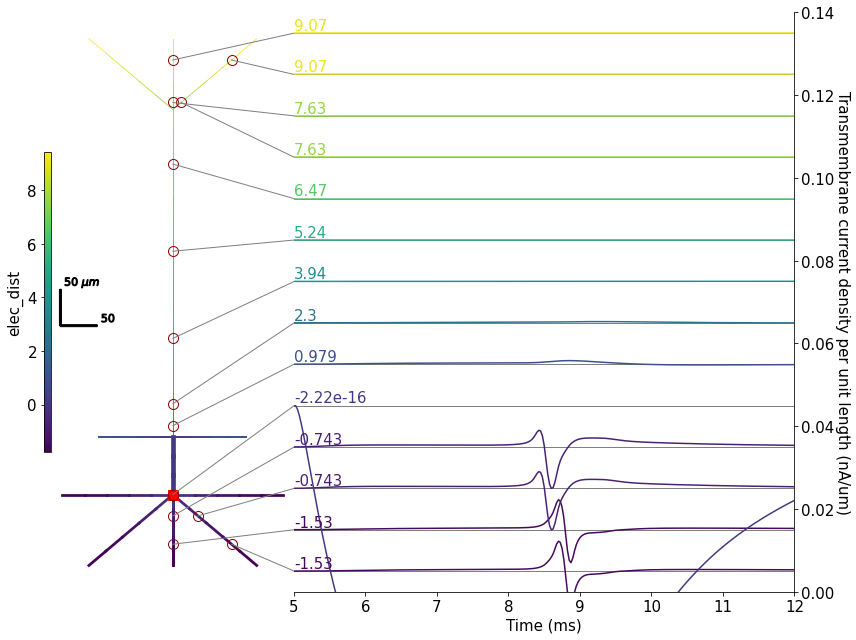

In [17]:
_ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t[t_idx], axes=axes,
                                  distance_type='elec_dist', n_dist=n_dist,
                                  select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
                                  space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
                                  figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)